<a href="https://colab.research.google.com/github/MACILLAS/icshm21/blob/master/ICSHM_SP_Classification_with_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Multi-class Classification with VGG19

### Import Packages

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

### Data download

We'll download our dataset from Roboflow. To download the dataset, use the "**Folder Structure**" export format.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

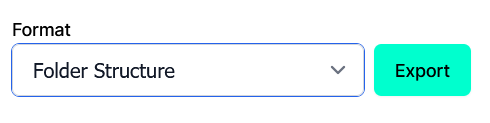


In [4]:
!curl -L "https://app.roboflow.com/ds/SGEZwh7PST?key=BslqSDpCxy" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

Streaming output truncated to the last 5000 lines.
 extracting: valid/wall/51_A10240_png.rf.46d72552c412771bb9e3e6c5f761d3d8.jpg  
 extracting: valid/wall/51_A10334_png.rf.5a8723623c4573bed39cbd027784429e.jpg  
 extracting: valid/wall/51_A10424_png.rf.c3e6080296b808de907a325401552c3f.jpg  
 extracting: valid/wall/51_A10451_png.rf.6cbd5a247b040d39a88999b05e423c4e.jpg  
 extracting: valid/wall/51_A10542_png.rf.5598558cb7fa2b25e85ce69a929f9c39.jpg  
 extracting: valid/wall/51_A20351_png.rf.4b11fa723faa994f9528f7530d5f6a3e.jpg  
 extracting: valid/wall/51_A30552_png.rf.056cefc84f94d8c8c51dfff74b0a33f4.jpg  
 extracting: valid/wall/51_A30586_png.rf.a8067b1fd276fdf340262fe353715b7d.jpg  
 extracting: valid/wall/51_A60067_png.rf.cffae98ba13e08b686e985d71cf457d2.jpg  
 extracting: valid/wall/51_A60185_png.rf.5984a2f16978667137f707df17358dd3.jpg  
 extracting: valid/wall/51_A60209_png.rf.16cb8e00eb44ed0239ca5398d96b2125.jpg  
 extracting: valid/wall/51_B20156_png.rf.8227d83f94902103afa7d19eea07

We need to turn this dataset into a Tensorflow Dataset format. Fortunately, Tensorflow provides the ImageFolder dataset structure which is compatible with the format we downloaded the data in. 

We will then use the builder to build the raw versions of our train, test, and validation data.

In [5]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
#raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=83399,
    splits={
        'train': 69487,
        'valid': 13912,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



Show images and labels from the training set:

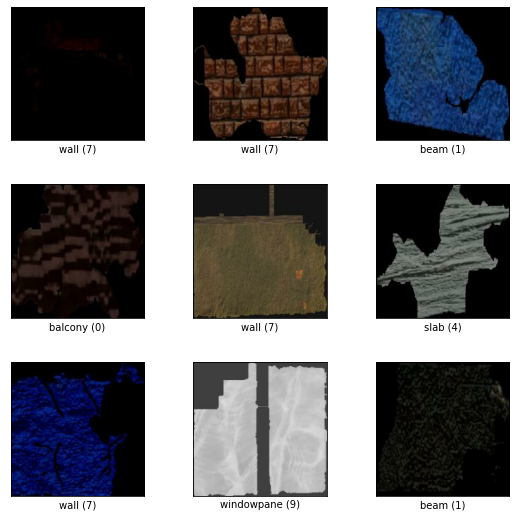

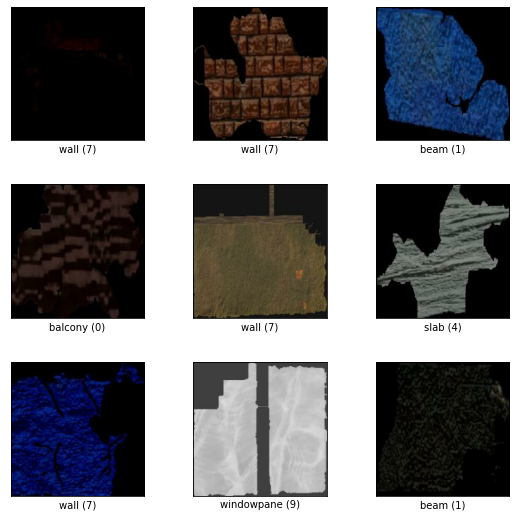

In [6]:
tfds.show_examples(raw_train, builder.info)

### Format the Data

We can use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

224x224 is the default image size for VGG19

In [7]:
IMG_SIZE = 224 # All images will be resized to 224x224

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset using the map method:

In [8]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
#test = raw_test.map(format_example)

Now shuffle and batch the data.

In [9]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
#test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data:

In [11]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([64, 224, 224, 3])

## Create VGG19 base model 

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from randomly initialized VGG19
base_model = tf.keras.applications.vgg19.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False, weights=None)

### Train from convolutional base

If you were fine-tuning, you should freeze the base model layers and only train the classifier head. That is a little too complex for this model so we are pretty much only going to use VGG19, which is a relatively small model anyways. 

Long story short...

In [13]:
base_model.trainable = True

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Apply `tf.keras.layers.Flatten` and several `tf.keras.layers.Dense` layers to convert feature maps from VGG19 to predictions. You need to use a 'softmax' function per usual for multi-class classification tasks. 

In [15]:
flatten = tf.keras.layers.Flatten()
pred_layer_1 = tf.keras.layers.Dense(64, activation='relu')
pred_layer_2 = tf.keras.layers.Dense(32, activation='relu')
softmax_layer = tf.keras.layers.Dense(8, activation='softmax') # 8 class classification

Now stack the feature extractor  (VGG19), and these four layers using a `tf.keras.Sequential` model:

In [16]:
model = tf.keras.Sequential([
  base_model,
  flatten,
  pred_layer_1,
  pred_layer_2,
  softmax_layer
])

### Compile the model

You must compile the model before training it.  Since there are 8 classes, use a sparse categorical cross-entropy loss.

In [17]:
base_learning_rate = 0.0001

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 21,632,424
Trainable params: 21,632,424
Non-trainable params: 0
_________________________________________________________________


In [19]:
len(model.trainable_variables)

38

### Train the model

After training for 20 epochs, you should see ~90%+ accuracy.


In [20]:
initial_epochs = 32
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 9s 136ms/step - loss: nan - accuracy: 0.1813


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: nan
initial accuracy: 0.18


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches, callbacks=[model_checkpoint_callback])

Epoch 1/32
  51/1086 [>.............................] - ETA: 8:22 - loss: nan - accuracy: 0.1602

### Save Model

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')
!zip -r ./saved_model.zip ./saved_model

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model.h5')
new_model.summary()


### Zip and Download

In [ ]:
from google.colab import files
files.download("/content/saved_model.zip")

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
same_model = tf.keras.models.load_model('saved_model/my_model')
same_model.summary()